In [1]:
# import general libraries for data manipulation   
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix 
warnings.filterwarnings("ignore")
from surprise import Reader, Dataset, SVD, KNNBaseline
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict

c:\Users\rauna\Anaconda3\envs\scaler\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\rauna\Anaconda3\envs\scaler\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\rauna\Anaconda3\envs\scaler\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Loading Data

In [2]:
movies = pd.read_fwf('ZEE-data/zee-movies.dat', encoding='ISO-8859-1')
ratings = pd.read_fwf('ZEE-data/zee-ratings.dat', encoding='ISO-8859-1')
users = pd.read_fwf('ZEE-data/zee-users.dat', encoding='ISO-8859-1')

# Preprocessing

In [3]:
movies.drop(columns=['Unnamed: 1','Unnamed: 2'], inplace=True)
movies = movies['Movie ID::Title::Genres'].str.split('::', expand=True)
movies.columns = ['Movie ID', 'Title', 'Genres']
display(movies.head())
print(movies.shape)

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


(3883, 3)


In [4]:
# do same for ratings
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split('::', expand=True)
ratings.columns = ['User ID', 'Movie ID', 'Rating', 'Timestamp']
ratings.drop(columns=['Timestamp'], inplace=True)
display(ratings.head())
print(ratings.shape)

,User ID,Movie ID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


(1000209, 3)


In [5]:
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::', expand=True)
users.columns = ['User ID', 'Gender', 'Age', 'Occupation','Zip-code']
users.drop(columns=['Zip-code'], inplace=True)
display(users.head())
print(users.shape)

,User ID,Gender,Age,Occupation
0,1,F,1,10
1,2,M,56,16
2,3,M,25,15
3,4,M,45,7
4,5,M,25,20


(6040, 4)


In [6]:
# merge the dataframes
df = pd.merge(movies, ratings, on='Movie ID')
df = pd.merge(df, users, on='User ID')
display(df.head())
print(df.shape)

,Movie ID,Title,Genres,User ID,Rating,Gender,Age,Occupation
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,F,1,10
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,F,1,10
2,150,Apollo 13 (1995),Drama,1,5,F,1,10
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantas,1,4,F,1,10
4,527,Schindler's List (1993),Drama|War,1,5,F,1,10


(1000209, 8)


# EDA

In [7]:
df.shape, users.shape, movies.shape

((1000209, 8), (6040, 4), (3883, 3))

- We have 1 million ratings from 6000 users on 4000 movies

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Movie ID    1000209 non-null  object
 1   Title       1000209 non-null  object
 2   Genres      996144 non-null   object
 3   User ID     1000209 non-null  object
 4   Rating      1000209 non-null  object
 5   Gender      1000209 non-null  object
 6   Age         1000209 non-null  object
 7   Occupation  1000209 non-null  object
dtypes: object(8)
memory usage: 68.7+ MB


- Genres has some missing values 

In [9]:
for c in ['Rating', 'Age', 'Movie ID', 'User ID']:
    df[c] = df[c].astype('int') 

In [10]:
# data checks
display(df['User ID'].agg(['min','max']))
display(df['Movie ID'].agg(['min','max']))
display(df['Rating'].agg(['min','max']))
print(f"Minimum ratings per user :  {df.groupby('User ID').size().min()}")


min       1
max    6040
Name: User ID, dtype: int32

min       1
max    3952
Name: Movie ID, dtype: int32

min    1
max    5
Name: Rating, dtype: int32

Minimum ratings per user :  20


- All the above checks are in line with data description

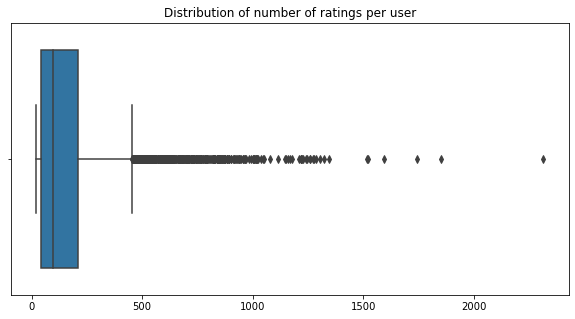

In [11]:
# Outlier detection
plt.figure(figsize=(10,5))
sns.boxplot(df.groupby('User ID').size())
plt.title('Distribution of number of ratings per user')
plt.show()


In [12]:
# write function to remove outliers using IQR
def remove_outliers(df, col, k=1.5):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (k * iqr)
    upper_bound = q3 + (k * iqr)
    return df[(df[col] > lower_bound) & (df[col] < upper_bound)]


In [13]:
valid_users = remove_outliers(pd.DataFrame(df.groupby('User ID').size()), col=0, k=1.5).index

In [14]:
print(df['User ID'].nunique(), valid_users.nunique(), df['Movie ID'].nunique())
df = df[df['User ID'].isin(valid_users)]
print(df['User ID'].nunique(), valid_users.nunique(), df['Movie ID'].nunique())

6040 5564 3706
5564 5564 3613


## Feature Creation

In [15]:
# create a new column for year
df['ReleaseYear'] = df['Title'].str.extract('.*\((.*)\).*', expand=True)

# create new feature for total number of words in title
df['TitleWordCount'] = df['Title'].str.split().str.len()

# create new feature for number of genres
df['GenreCount'] = df['Genres'].str.count('\|') + 1
df['GenreCount'].fillna(0, inplace=True)

In [16]:
df.head()

,Movie ID,Title,Genres,User ID,Rating,Gender,Age,Occupation,ReleaseYear,TitleWordCount,GenreCount
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,F,1,10,1995,3,3.0
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,F,1,10,1995,2,4.0
2,150,Apollo 13 (1995),Drama,1,5,F,1,10,1995,3,1.0
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantas,1,4,F,1,10,1977,9,3.0
4,527,Schindler's List (1993),Drama|War,1,5,F,1,10,1993,3,2.0


In [17]:
df_grouped = df.groupby('User ID').agg({'Rating': ['count', 'mean'],'Gender': 'first', 'Age': 'first', 'Occupation': 'first'}).copy()
df_grouped.columns = ['_'.join(col).strip() for col in df_grouped.columns.values]
df_grouped.reset_index(inplace=True)
df_grouped.rename(columns={'Gender_first': 'Gender', 'Age_first': 'Age', 'Occupation_first':'Occupation'}, inplace=True)
display(df_grouped.head())
print(df_grouped.shape)


,User ID,Rating_count,Rating_mean,Gender,Age,Occupation
0,1,53,4.188679,F,1,10
1,2,129,3.713178,M,56,16
2,3,51,3.901961,M,25,15
3,4,21,4.190476,M,45,7
4,5,198,3.146465,M,25,20


(5564, 6)


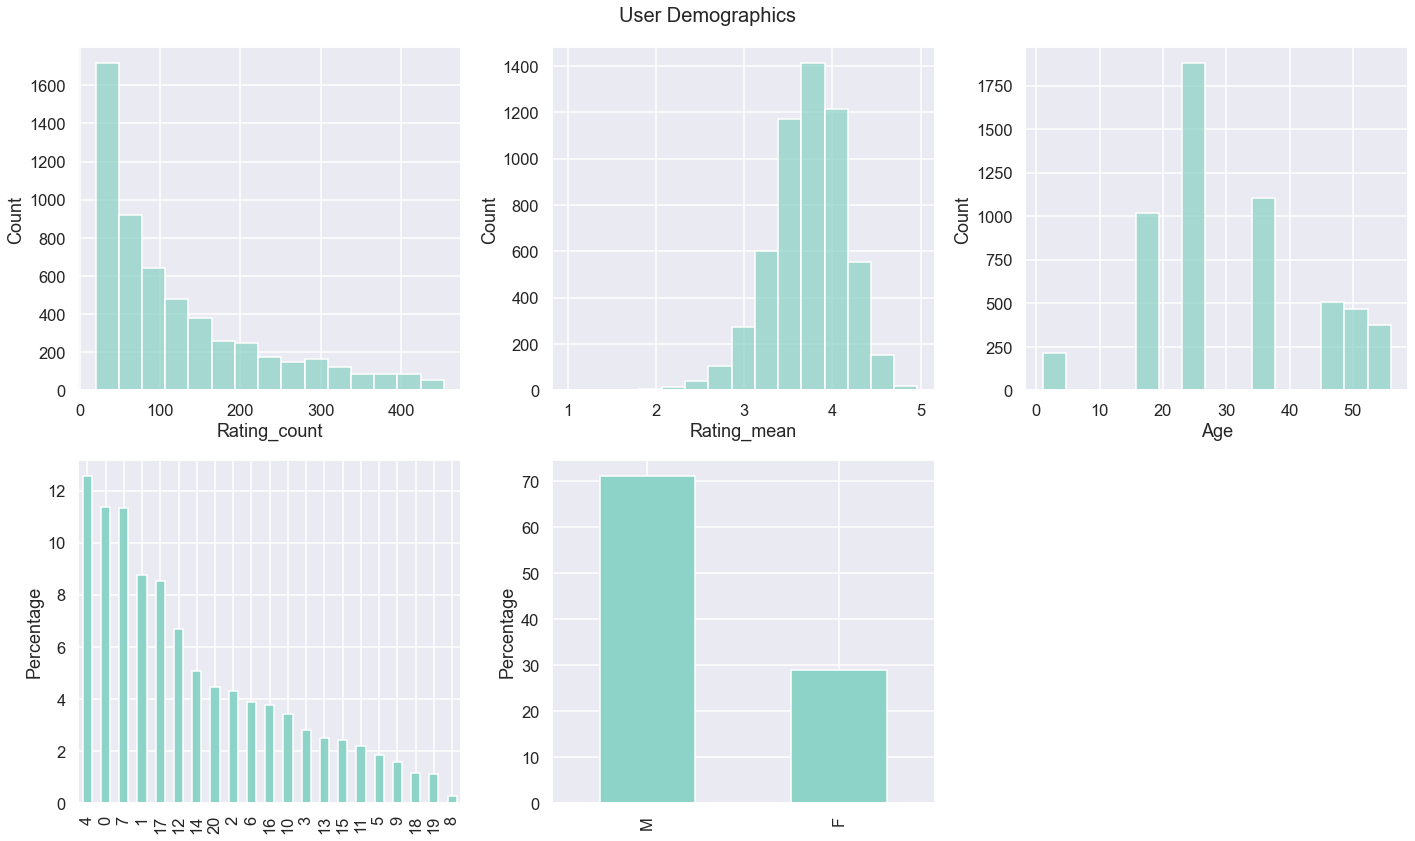

In [18]:
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_palette('Set3')
plt.rcParams['figure.autolayout'] = True

fig,axes = plt.subplots(2,3,figsize=(20, 12))
# set title
fig.suptitle('User Demographics', fontsize=20)
for e,c in enumerate(['Rating_count', 'Rating_mean', 'Age', 'Occupation','Gender']):
    if df_grouped[c].dtype == 'object':
        # plot countplot as percentage
        (df_grouped[c].value_counts(normalize=True)*100).plot(kind='bar', ax=axes[e//3,e%3])
        axes[e//3,e%3].set_ylabel('Percentage')
    else:
        sns.histplot(df_grouped[c], ax=axes[e//3,e%3], bins=15)
# remove last subplot
fig.delaxes(axes[1,2])
plt.show()


- Users have an exponential distribution when it comes to # of movies rated
- Users usually rate movies between 3 and 4
- Primary user base is in 20s
- College/Grad Student makes up the highest of our user base ~ 12% 
- 70 % of users are male 


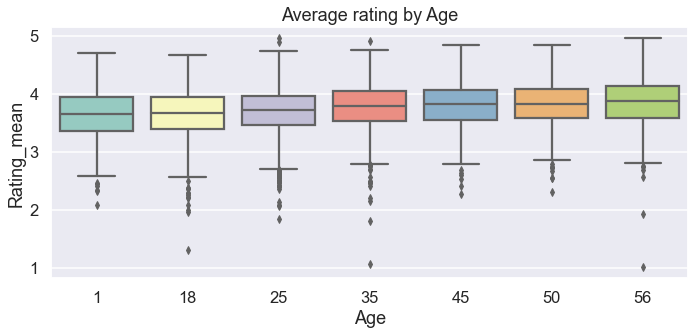

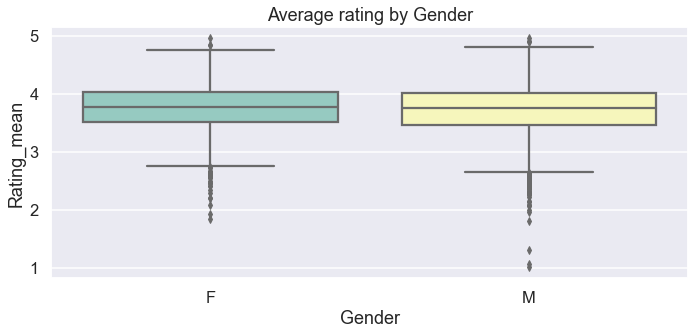

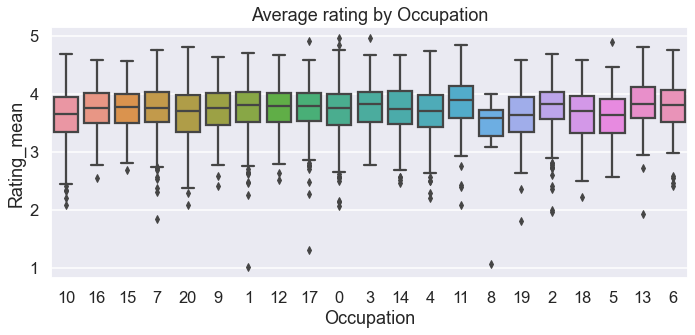

In [19]:
for e,c in enumerate(['Age','Gender','Occupation']):
    plt.figure(figsize=(10,5))
    sns.boxplot(x=c, y='Rating_mean', data=df_grouped)
    plt.title(f'Average rating by {c}')
    plt.show()

- There is a slight positive relationship between age and average user rating showing older people are less critical
- Gender doesnt have much difference in ratings
- Occupation 8 ie Farmers rate the lowest on average

In [20]:
# Creating a pivot table of movie titles & user id and imputing the NaN values with a suitable value
user_movie_ratings = df.pivot_table(index='User ID', columns='Movie ID', values='Rating').fillna(0)
display(user_movie_ratings.head())
print(user_movie_ratings.shape)

Movie ID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
User ID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(5564, 3613)


In [21]:
print(f"Empty percentage : {round((user_movie_ratings == 0).mean().mean() * 100,1)} %")

Empty percentage : 96.7 %


# Recommendation System

In [22]:
df.head()

,Movie ID,Title,Genres,User ID,Rating,Gender,Age,Occupation,ReleaseYear,TitleWordCount,GenreCount
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,F,1,10,1995,3,3.0
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,F,1,10,1995,2,4.0
2,150,Apollo 13 (1995),Drama,1,5,F,1,10,1995,3,1.0
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantas,1,4,F,1,10,1977,9,3.0
4,527,Schindler's List (1993),Drama|War,1,5,F,1,10,1993,3,2.0


In [23]:
# Setting up
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['User ID', 'Movie ID', 'Rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)    

In [24]:
def build_rec_sys(algo):
    algo.fit(trainset)
    predictions = algo.test(testset)
    print(f"Test RMSE : {round(accuracy.rmse(predictions),2)} ,Test MAE: {round(accuracy.mae(predictions), 2)}")
    return algo, predictions

## Using Pearson Correlation

In [25]:
model_1 , predictions_1 = build_rec_sys(KNNBaseline(sim_options={'name': 'pearson_baseline', 'user_based': False}))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8820
MAE:  0.6894
Test RMSE : 0.88 ,Test MAE: 0.69


In [26]:
movie_dict = dict(zip(df['Movie ID'], df['Title'])) 

def get_top_n(predictions, movie_dict, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((movie_dict[iid], est ))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x : x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [27]:
top_n_1 = get_top_n(predictions_1, movie_dict, n=10)

### Top 10 recommendations for user 1


In [28]:
user_1 = df[df['User ID'] == 1]
user_1 = user_1[['User ID', 'Movie ID', 'Title', 'Rating']]
print('\nMovies liked by user 1: ')
display(user_1.sort_values('Rating', ascending=False).head(10))
print('\nTop 10 recommendations for user 1')
for e,i in enumerate(top_n_1[1]):
    print(f"{e+1}. {i[0]} with predicted rating {round(i[1],2)}")


Movies liked by user 1: 


,User ID,Movie ID,Title,Rating
0,1,1,Toy Story (1995),5
17,1,1022,Cinderella (1950),5
49,1,3105,Awakenings (1990),5
47,1,2804,"Christmas Story, A (1983)",5
40,1,2355,"Bug's Life, A (1998)",5
36,1,2028,Saving Private Ryan (1998),5
33,1,1961,Rain Man (1988),5
31,1,1836,"Last Days of Disco, The (1998)",5
27,1,1287,Ben-Hur (1959),5
1,1,48,Pocahontas (1995),5



Top 10 recommendations for user 1
1. Wizard of Oz, The (1939) with predicted rating 4.72
2. Ben-Hur (1959) with predicted rating 4.6
3. Star Wars: Episode IV - A New Hope (1977) with predicted rating 4.55
4. E.T. the Extra-Terrestrial (1982) with predicted rating 4.45
5. Dead Poets Society (1989) with predicted rating 4.39
6. Beauty and the Beast (1991) with predicted rating 4.34
7. Tarzan (1999) with predicted rating 4.1
8. Secret Garden, The (1993) with predicted rating 3.91
9. Hunchback of Notre Dame, The (1996) with predicted rating 3.8
10. Antz (1998) with predicted rating 3.59


### Top 10 movies similar to Toy Story (1995)

In [38]:
toy_story_raw_id = df[df['Title'] == 'Toy Story (1995)']['Movie ID'].iloc[0]

In [30]:
[movie_dict[trainset.to_raw_iid(i)] for i in model_1.get_neighbors(trainset.to_inner_iid(toy_story_raw_id), k=10)]

['Toy Story 2 (1999)',
 "Bug's Life, A (1998)",
 'Aladdin (1992)',
 'Beauty and the Beast (1991)',
 'Honey, I Shrunk the Kids (1989)',
 'Muppet Movie, The (1979)',
 'Babe (1995)',
 'Lion King, The (1994)',
 'Tarzan (1999)',
 'Cinderella (1950)']

## Using Cosine Similarity

### Item Item Similiarity

In [31]:
model_2 , predictions_2 = build_rec_sys(KNNBaseline(sim_options={'name': 'cosine', 'user_based': False}))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9112
MAE:  0.7167
Test RMSE : 0.91 ,Test MAE: 0.72


In [36]:
item_similarity_matrix = pd.DataFrame(model_2.compute_similarities())
item_similarity_matrix.index = item_similarity_matrix.index.map(lambda x : movie_dict[trainset.to_raw_iid(x)])
item_similarity_matrix.columns = item_similarity_matrix.index
item_similarity_matrix.head()

Computing the cosine similarity matrix...
Done computing similarity matrix.


,"First Wives Club, The (1996)",Sphere (1998),L.A. Confidential (1997),"Rocky Horror Picture Show, The (1975)",Lone Star (1996),Stand by Me (1986),On the Waterfront (1954),Chinatown (1974),American Beauty (1999),When Harry Met Sally... (1989),...,Follow the Bitch (1998),"Loves of Carmen, The (1948)",Something to Sing About (1937),"To Have, or Not (1995)",Mutters Courage (1995),Tough and Deadly (1995),Race the Sun (1996),Johnny 100 Pesos (1993),Eden (1997),Feast of July (1995)
"First Wives Club, The (1996)",1.000000,0.926677,0.957309,0.923407,0.962500,0.949004,0.954030,0.940702,0.914835,0.944449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sphere (1998),0.926677,1.000000,0.927770,0.875052,0.926874,0.934048,0.879211,0.906055,0.929062,0.949834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L.A. Confidential (1997),0.957309,0.927770,1.000000,0.929263,0.970224,0.969329,0.974220,0.981593,0.972281,0.967357,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"Rocky Horror Picture Show, The (1975)",0.923407,0.875052,0.929263,1.000000,0.936119,0.917318,0.910525,0.931787,0.922864,0.929721,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Lone Star (1996),0.962500,0.926874,0.970224,0.936119,1.000000,0.963328,0.980775,0.977182,0.961582,0.973186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Top 10 movies similar to Toy Story (1995)

In [41]:
[movie_dict[trainset.to_raw_iid(i)] for i in model_2.get_neighbors(trainset.to_inner_iid(toy_story_raw_id), k=10)]

['Rendezvous in Paris (Rendez-vous de Paris, Les) (1995)',
 'Buck and the Preacher (1972)',
 'Bad Moon (1996)',
 'Ape, The (1940)',
 'Solas (1999)',
 'Solar Crisis (1993)',
 'Story of G.I. Joe, The (1945)',
 'Little Lord Fauntleroy (1936)',
 "Don't Look in the Basement! (1973)",
 'Saltmen of Tibet, The (1997)']

### User User Similarity

In [42]:
model_3 , predictions_3 = build_rec_sys(KNNBaseline(sim_options={'name': 'cosine', 'user_based': True}))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9165
MAE:  0.7232
Test RMSE : 0.92 ,Test MAE: 0.72


In [43]:
user_similarity_matrix = pd.DataFrame(model_3.compute_similarities())
user_similarity_matrix.head()

Computing the cosine similarity matrix...
Done computing similarity matrix.


,0,1,2,3,4,5,6,7,8,9,...,5554,5555,5556,5557,5558,5559,5560,5561,5562,5563
0,1.000000,0.991837,0.993809,0.992171,0.972677,0.957209,0.962583,0.938436,0.934335,0.967686,...,1.000000,0.992302,0.917319,0.000000,0.979798,0.991837,0.000000,0.989949,0.999630,0.990992
1,0.991837,1.000000,0.994850,0.967989,0.913393,0.993610,0.966842,0.936390,0.962720,0.873440,...,1.000000,1.000000,1.000000,0.978768,0.959547,1.000000,1.000000,0.000000,1.000000,0.000000
2,0.993809,0.994850,1.000000,0.994536,0.970429,0.990947,0.991408,0.972369,0.947534,0.990260,...,0.972229,1.000000,1.000000,0.000000,1.000000,0.982302,0.000000,0.994937,1.000000,0.000000
3,0.992171,0.967989,0.994536,1.000000,0.942957,0.987541,0.972629,0.968922,1.000000,0.788950,...,1.000000,0.000000,1.000000,1.000000,0.995871,1.000000,0.000000,1.000000,0.990867,1.000000
4,0.972677,0.913393,0.970429,0.942957,1.000000,0.968521,0.963240,0.944295,0.956269,0.942986,...,0.936980,0.994426,0.944831,0.980581,0.982293,0.960277,0.916634,0.969805,0.975551,0.974835


### Top 10 recommendations for user 1

In [45]:
top_n_3 = get_top_n(predictions_3, movie_dict, n=10)

In [47]:
user_1 = df[df['User ID'] == 1]
user_1 = user_1[['User ID', 'Movie ID', 'Title', 'Rating']]
print('\nMovies liked by user 1: ')
display(user_1.sort_values('Rating', ascending=False).head(10))
print('\nTop 10 recommendations for user 1')
for e,i in enumerate(top_n_3[1]):
    print(f"{e+1}. {i[0]} with predicted rating {round(i[1],2)}")


Movies liked by user 1: 


,User ID,Movie ID,Title,Rating
0,1,1,Toy Story (1995),5
17,1,1022,Cinderella (1950),5
49,1,3105,Awakenings (1990),5
47,1,2804,"Christmas Story, A (1983)",5
40,1,2355,"Bug's Life, A (1998)",5
36,1,2028,Saving Private Ryan (1998),5
33,1,1961,Rain Man (1988),5
31,1,1836,"Last Days of Disco, The (1998)",5
27,1,1287,Ben-Hur (1959),5
1,1,48,Pocahontas (1995),5



Top 10 recommendations for user 1
1. Star Wars: Episode IV - A New Hope (1977) with predicted rating 4.53
2. Wizard of Oz, The (1939) with predicted rating 4.51
3. Ben-Hur (1959) with predicted rating 4.25
4. Dead Poets Society (1989) with predicted rating 4.24
5. Beauty and the Beast (1991) with predicted rating 4.17
6. Secret Garden, The (1993) with predicted rating 4.02
7. Tarzan (1999) with predicted rating 3.96
8. E.T. the Extra-Terrestrial (1982) with predicted rating 3.77
9. Antz (1998) with predicted rating 3.7
10. Hunchback of Notre Dame, The (1996) with predicted rating 3.64


## Using Matrix Decomposition

In [52]:
model_4 , predictions_4 = build_rec_sys(SVD(n_factors=4, n_epochs=100))

RMSE: 0.8881
MAE:  0.6934
Test RMSE : 0.89 ,Test MAE: 0.69


### Top 10 recommendations for user 1

In [54]:
top_n_4 = get_top_n(predictions_4, movie_dict, n=10)

In [55]:
user_1 = df[df['User ID'] == 1]
user_1 = user_1[['User ID', 'Movie ID', 'Title', 'Rating']]
print('\nMovies liked by user 1: ')
display(user_1.sort_values('Rating', ascending=False).head(10))
print('\nTop 10 recommendations for user 1')
for e,i in enumerate(top_n_4[1]):
    print(f"{e+1}. {i[0]} with predicted rating {round(i[1],2)}")


Movies liked by user 1: 


,User ID,Movie ID,Title,Rating
0,1,1,Toy Story (1995),5
17,1,1022,Cinderella (1950),5
49,1,3105,Awakenings (1990),5
47,1,2804,"Christmas Story, A (1983)",5
40,1,2355,"Bug's Life, A (1998)",5
36,1,2028,Saving Private Ryan (1998),5
33,1,1961,Rain Man (1988),5
31,1,1836,"Last Days of Disco, The (1998)",5
27,1,1287,Ben-Hur (1959),5
1,1,48,Pocahontas (1995),5



Top 10 recommendations for user 1
1. Wizard of Oz, The (1939) with predicted rating 4.61
2. Star Wars: Episode IV - A New Hope (1977) with predicted rating 4.5
3. Ben-Hur (1959) with predicted rating 4.41
4. E.T. the Extra-Terrestrial (1982) with predicted rating 4.37
5. Dead Poets Society (1989) with predicted rating 4.34
6. Beauty and the Beast (1991) with predicted rating 4.28
7. Tarzan (1999) with predicted rating 4.06
8. Secret Garden, The (1993) with predicted rating 3.99
9. Antz (1998) with predicted rating 3.74
10. Hunchback of Notre Dame, The (1996) with predicted rating 3.68


### Embeddings

In [63]:
user_embeddings = pd.DataFrame(model_4.pu,
                            index=[trainset.to_raw_uid(i) for i in range(trainset.n_users)], 
                            columns=['Embedding_1', 'Embedding_2', 'Embedding_3', 'Embedding_4'])

items_embeddings = pd.DataFrame(model_4.qi,
                            index=[movie_dict[trainset.to_raw_iid(i)] for i in range(trainset.n_items)], 
                            columns=['Embedding_1', 'Embedding_2', 'Embedding_3', 'Embedding_4'])

In [64]:
print('User Embeddings : ')
display(user_embeddings.head(2))
print('\n\nItem Embeddings : ')
display(items_embeddings.head(2))

User Embeddings : 


,Embedding_1,Embedding_2,Embedding_3,Embedding_4
96,-0.449350,-0.053914,-0.329087,-0.260830
2101,0.388652,-0.174531,0.033435,0.921491




Item Embeddings : 


,Embedding_1,Embedding_2,Embedding_3,Embedding_4
"First Wives Club, The (1996)",-0.501219,-0.191519,-0.594369,-0.474218
Sphere (1998),-0.091231,0.331609,-0.044451,-0.739272


In [65]:
user_similarity_cosine = pd.DataFrame(cosine_similarity(user_embeddings), index=user_embeddings.index, columns=user_embeddings.index)
item_similarity_cosine = pd.DataFrame(cosine_similarity(items_embeddings), index=items_embeddings.index, columns=items_embeddings.index)

In [66]:
print('\nUser Similarity Matrix : ')
display(user_similarity_cosine.head(2))
print('\n\nItem Similarity Matrix : ')
display(item_similarity_cosine.head(2))



User Similarity Matrix : 


,96,2101,5846,2284,1984,1699,2185,5699,1965,4645,...,2373,171,2277,2871,790,3287,3530,907,4176,2673
96,1.000000,-0.664299,0.310701,-0.620868,0.354540,0.081156,0.230757,-0.713970,0.523546,0.968730,...,-0.387035,0.615083,0.514866,-0.035803,0.535298,0.430388,0.491624,-0.172330,-0.645253,0.397369
2101,-0.664299,1.000000,0.336351,0.841520,-0.393141,0.626136,0.523050,0.979375,-0.038019,-0.652705,...,-0.366917,0.169441,-0.544694,0.601566,-0.860512,-0.047867,-0.793588,0.342267,0.947820,0.252547




Item Similarity Matrix : 


,"First Wives Club, The (1996)",Sphere (1998),L.A. Confidential (1997),"Rocky Horror Picture Show, The (1975)",Lone Star (1996),Stand by Me (1986),On the Waterfront (1954),Chinatown (1974),American Beauty (1999),When Harry Met Sally... (1989),...,Follow the Bitch (1998),"Loves of Carmen, The (1948)",Something to Sing About (1937),"To Have, or Not (1995)",Mutters Courage (1995),Tough and Deadly (1995),Race the Sun (1996),Johnny 100 Pesos (1993),Eden (1997),Feast of July (1995)
"First Wives Club, The (1996)",1.000000,0.472701,-0.587955,-0.438781,0.134283,-0.484963,-0.233838,-0.466187,-0.808561,0.215004,...,-0.496400,-0.086608,0.735576,0.410652,0.130206,0.456937,-0.290464,0.076934,0.161144,-0.228311
Sphere (1998),0.472701,1.000000,-0.943650,-0.429908,-0.653336,-0.676069,-0.947037,-0.787606,-0.448601,-0.536750,...,0.256531,0.812206,0.575178,-0.337155,0.108601,0.124842,-0.727258,-0.819481,0.212824,-0.723854


#### Top 10 movies similar to Toy Story (1995)

In [71]:
item_similarity_cosine['Toy Story (1995)'].sort_values(ascending=False).head(11)

Toy Story (1995)                      1.000000
Jungle Book, The (1967)               0.996004
Splash (1984)                         0.991048
E.T. the Extra-Terrestrial (1982)     0.989616
Muppet Christmas Carol, The (1992)    0.984511
Sleeping Beauty (1959)                0.981426
Old Yeller (1957)                     0.981204
Big (1988)                            0.974407
Oliver! (1968)                        0.968310
Ayn Rand: A Sense of Life (1997)      0.967853
Rescuers, The (1977)                  0.966946
Name: Toy Story (1995), dtype: float64

### Embeddings Visulization with d=2

In [72]:
model_5 , predictions_5 = build_rec_sys(SVD(n_factors=2, n_epochs=200))

RMSE: 0.8889
MAE:  0.6964
Test RMSE : 0.89 ,Test MAE: 0.7


In [159]:
user_embeddings = pd.DataFrame(model_5.pu,
                            index=[trainset.to_raw_uid(i) for i in range(trainset.n_users)], 
                            columns=['Embedding_1', 'Embedding_2'])

items_embeddings = pd.DataFrame(model_5.qi,
                            index=[movie_dict[trainset.to_raw_iid(i)] for i in range(trainset.n_items)], 
                            columns=['Embedding_1', 'Embedding_2'])

In [160]:
# merge item embeddings with movie data
items_embeddings = movies.merge(items_embeddings, left_on='Title', right_index=True)

# extract year from title
items_embeddings['year'] = items_embeddings['Title'].str.extract('.*\((.*)\).*', expand=False)
items_embeddings['year'] = pd.to_numeric(items_embeddings['year'], errors='coerce')
items_embeddings['released_after_1995'] = (items_embeddings['year'] > 1995)

# extract number of genres from Genre
items_embeddings['genre_count'] = items_embeddings['Genres'].str.count('\|') + 1
items_embeddings['multiple_genre'] = (items_embeddings['genre_count'] > 1)


display(items_embeddings.head(2))

,Movie ID,Title,Genres,Embedding_1,Embedding_2,year,released_after_1995,genre_count,multiple_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,0.385643,0.232034,1995.0,False,3.0,True
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0.605638,-0.419186,1995.0,False,3.0,True


In [165]:
# merge user embeddings with user data
users['User ID'] = users['User ID'].astype('int')
users['Age'] = users['Age'].astype('int')
user_embeddings = users.merge(user_embeddings, left_on='User ID', right_index=True)
user_embeddings['older_than_30'] = (user_embeddings['Age'] > 30)

display(user_embeddings.head(2))

,User ID,Gender,Age,Occupation,Embedding_1,Embedding_2,older_than_30
0,1,F,1,10,0.573303,-0.115888,False
1,2,M,56,16,0.854225,-0.092019,True


Text(0.5, 1.0, 'Item Embeddings : Multiple Genre')

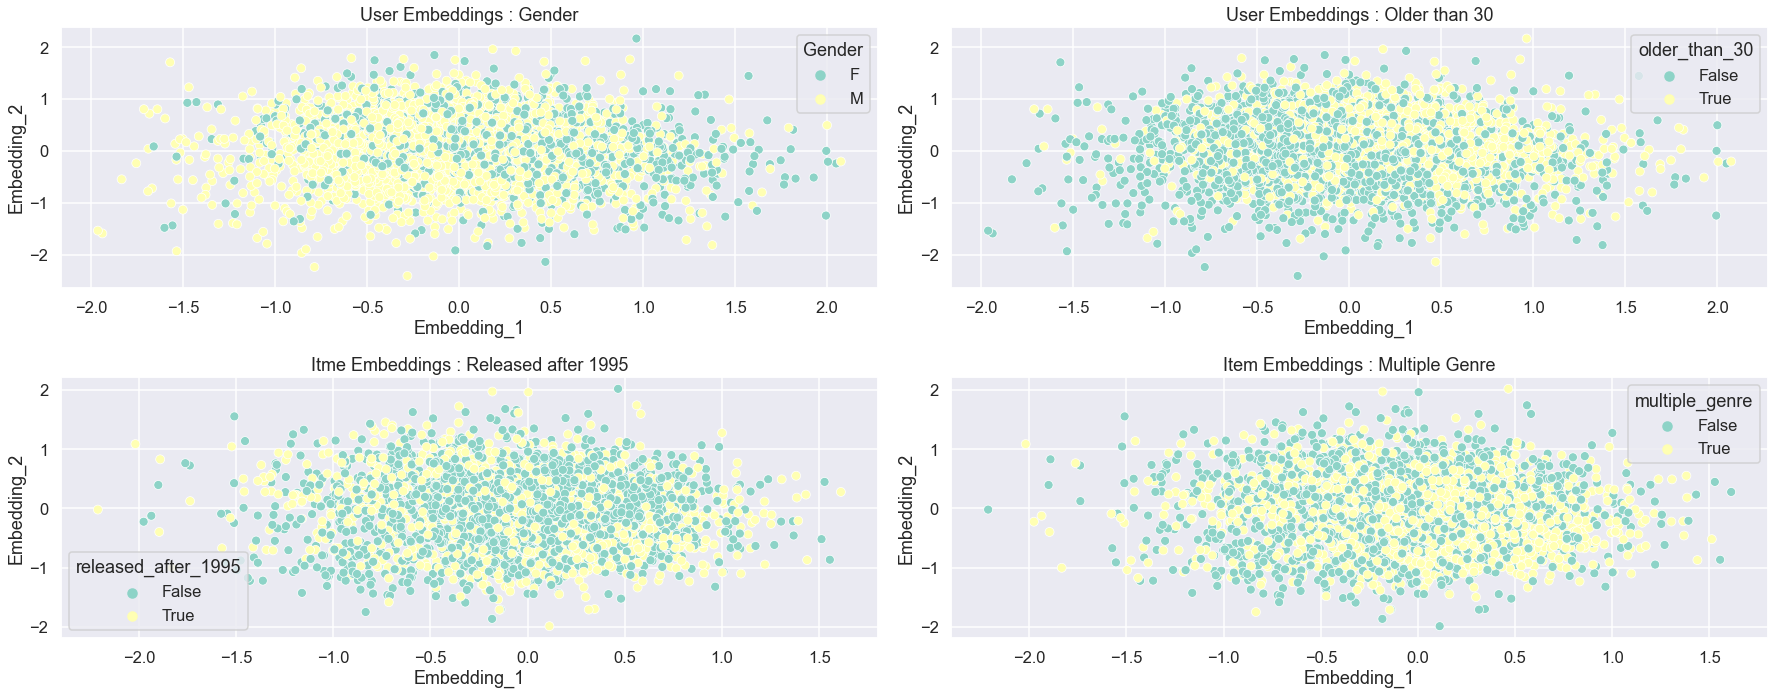

In [166]:
fig,ax = plt.subplots(2,2,figsize=(25, 10))
sns.scatterplot(x='Embedding_1', y='Embedding_2', data=user_embeddings, hue='Gender', ax=ax[0,0])
ax[0,0].set_title('User Embeddings : Gender')
sns.scatterplot(x='Embedding_1', y='Embedding_2', data=user_embeddings, hue='older_than_30', ax=ax[0,1])
ax[0,1].set_title('User Embeddings : Older than 30')

sns.scatterplot(x='Embedding_1', y='Embedding_2', data=items_embeddings, hue='released_after_1995', ax=ax[1,0])
ax[1,0].set_title('Itme Embeddings : Released after 1995')
sns.scatterplot(x='Embedding_1', y='Embedding_2', data=items_embeddings, hue='multiple_genre', ax=ax[1,1])
ax[1,1].set_title('Item Embeddings : Multiple Genre')

- No correlation between the embeddings 
- Embeddings have captured gender differences (female top right, male bottom left)  